In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional, Flatten, TimeDistributed, Reshape
import tensorflow as tf


# **8:2**

In [79]:
df = pd.read_csv('ETH.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229981,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1899,2024-05-12,2911.658203,2953.047363,2902.201904,2928.701904,2928.701904,5908941395
1900,2024-05-13,2928.813965,2994.869141,2865.134521,2949.359619,2949.359619,13352264795
1901,2024-05-14,2949.213135,2959.546631,2863.545898,2881.157959,2881.157959,12444516140
1902,2024-05-15,2881.224609,3041.602295,2864.735352,3037.056641,3037.056641,14666902956


In [80]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [81]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [82]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [83]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [84]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [85]:
# 8. Define LSTM Model
# Define the CNN model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [86]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
23/23 [==============================] - 4s 85ms/step - loss: 0.0331 - val_loss: 0.0080
Epoch 2/200
23/23 [==============================] - 2s 72ms/step - loss: 0.0102 - val_loss: 0.0078
Epoch 3/200
23/23 [==============================] - 2s 94ms/step - loss: 0.0085 - val_loss: 0.0054
Epoch 4/200
23/23 [==============================] - 3s 119ms/step - loss: 0.0060 - val_loss: 0.0043
Epoch 5/200
23/23 [==============================] - 2s 73ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 6/200
23/23 [==============================] - 2s 72ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 7/200
23/23 [==============================] - 2s 72ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 8/200
23/23 [==============================] - 2s 72ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 9/200
23/23 [==============================] - 2s 72ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 10/200
23/23 [==============================] - 2s 86ms/step - loss: 0.0028 - val_loss: 0.002

In [87]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 14ms/step


In [88]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [89]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 97.56250040167284
Testing MAPE: 2.5164150466192603
Testing MAE: 65.17190289751672


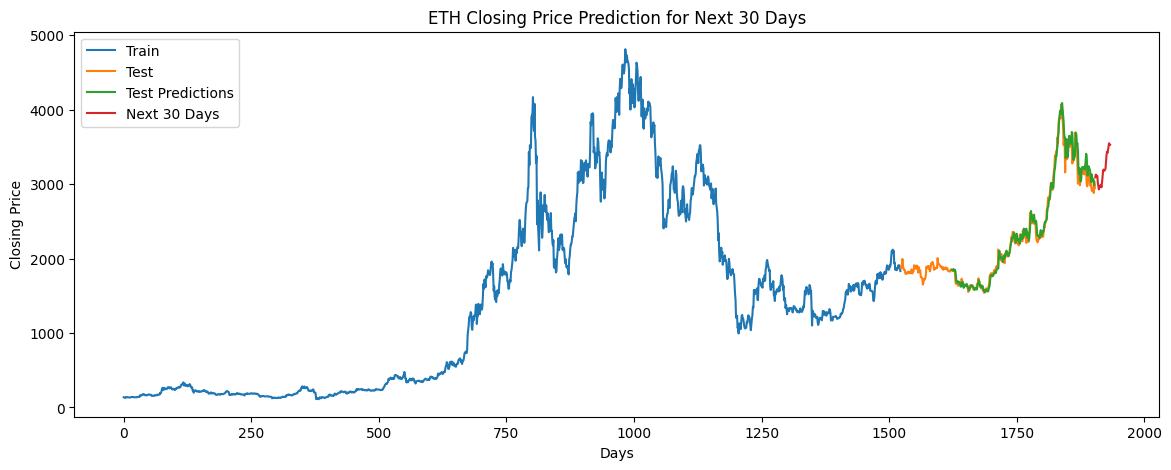

Predicted closing prices for the next 30 days:
[3091.4192 3127.0708 3121.6692 3103.741  3106.9783 3018.9685 2973.5522
 2929.0964 2956.505  2977.4104 2979.5007 2989.912  2957.0278 3010.162
 3080.3547 3159.403  3195.9539 3182.6277 3181.301  3191.8086 3206.792
 3297.2751 3389.4282 3431.9604 3418.6309 3460.556  3503.2793 3549.2585
 3533.803  3529.434 ]


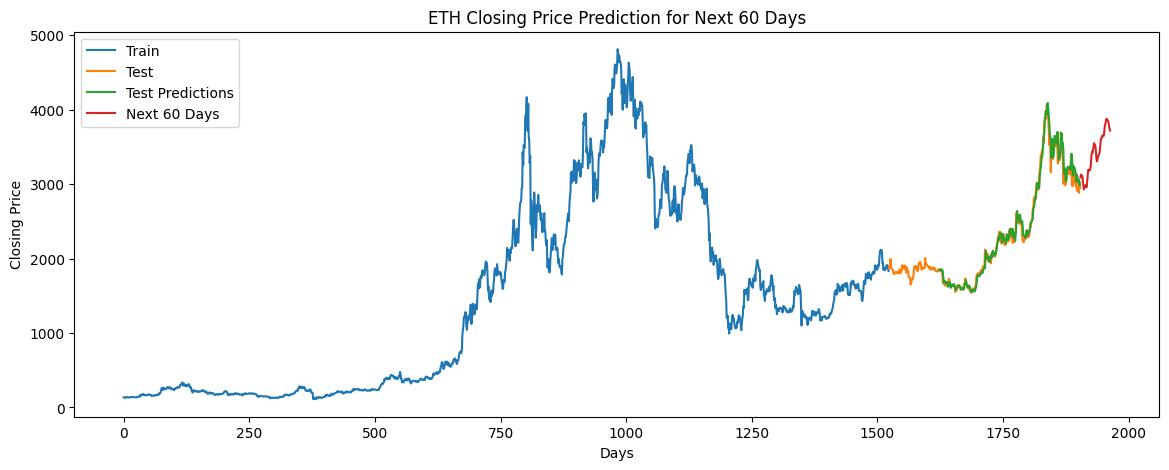

Predicted closing prices for the next 60 days:
[3091.4192 3127.0708 3121.6692 3103.741  3106.9783 3018.9685 2973.5522
 2929.0964 2956.505  2977.4104 2979.5007 2989.912  2957.0278 3010.162
 3080.3547 3159.403  3195.9539 3182.6277 3181.301  3191.8086 3206.792
 3297.2751 3389.4282 3431.9604 3418.6309 3460.556  3503.2793 3549.2585
 3533.803  3529.434  3497.582  3415.213  3330.9194 3303.9612 3333.1
 3365.7588 3387.954  3404.1494 3417.1335 3481.0361 3561.417  3613.4126
 3617.5828 3633.9246 3656.3296 3647.1682 3644.3044 3665.5703 3749.8887
 3802.9392 3812.5303 3867.7844 3878.2312 3867.1355 3857.17   3846.0415
 3825.2676 3772.5034 3745.1128 3719.027 ]


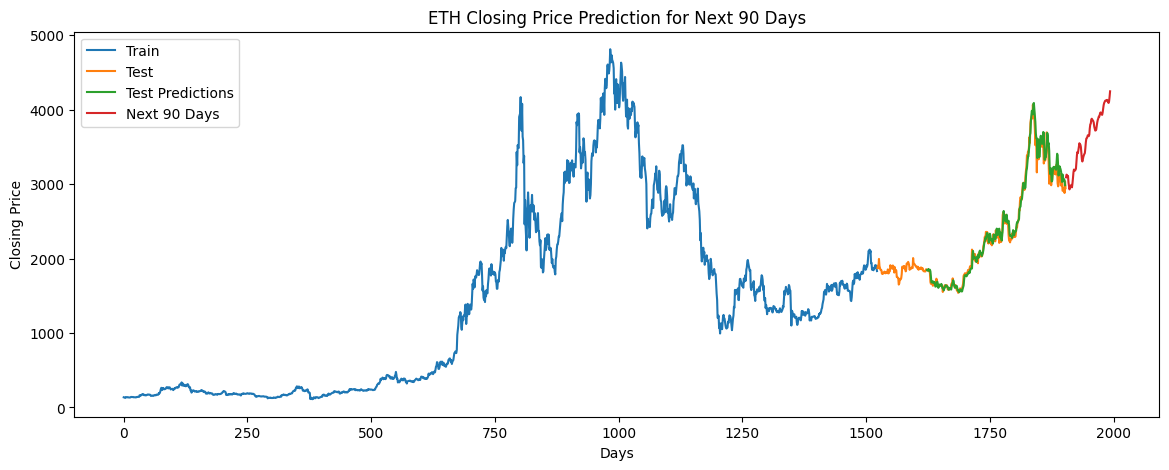

Predicted closing prices for the next 90 days:
[3091.4192 3127.0708 3121.6692 3103.741  3106.9783 3018.9685 2973.5522
 2929.0964 2956.505  2977.4104 2979.5007 2989.912  2957.0278 3010.162
 3080.3547 3159.403  3195.9539 3182.6277 3181.301  3191.8086 3206.792
 3297.2751 3389.4282 3431.9604 3418.6309 3460.556  3503.2793 3549.2585
 3533.803  3529.434  3497.582  3415.213  3330.9194 3303.9612 3333.1
 3365.7588 3387.954  3404.1494 3417.1335 3481.0361 3561.417  3613.4126
 3617.5828 3633.9246 3656.3296 3647.1682 3644.3044 3665.5703 3749.8887
 3802.9392 3812.5303 3867.7844 3878.2312 3867.1355 3857.17   3846.0415
 3825.2676 3772.5034 3745.1128 3719.027  3721.8552 3732.261  3779.6692
 3827.352  3860.2336 3878.3584 3905.2166 3903.797  3929.6355 3956.5334
 3963.104  3942.0251 3934.7615 3930.916  3962.1177 4013.911  4061.2131
 4089.8872 4103.654  4118.94   4123.1606 4124.9146 4121.5903 4131.399
 4121.6567 4098.978  4090.6265 4112.288  4173.798  4246.7183]


In [90]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'ETH Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **7:3**

In [91]:
df = pd.read_csv('ETH.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229981,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1899,2024-05-12,2911.658203,2953.047363,2902.201904,2928.701904,2928.701904,5908941395
1900,2024-05-13,2928.813965,2994.869141,2865.134521,2949.359619,2949.359619,13352264795
1901,2024-05-14,2949.213135,2959.546631,2863.545898,2881.157959,2881.157959,12444516140
1902,2024-05-15,2881.224609,3041.602295,2864.735352,3037.056641,3037.056641,14666902956


In [92]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [93]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [94]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [95]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [96]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [97]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [98]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
20/20 [==============================] - 4s 94ms/step - loss: 0.0394 - val_loss: 0.0049
Epoch 2/200
20/20 [==============================] - 2s 101ms/step - loss: 0.0122 - val_loss: 0.0045
Epoch 3/200
20/20 [==============================] - 2s 122ms/step - loss: 0.0092 - val_loss: 0.0042
Epoch 4/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 5/200
20/20 [==============================] - 2s 75ms/step - loss: 0.0060 - val_loss: 0.0028
Epoch 6/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 7/200
20/20 [==============================] - 1s 74ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 8/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 9/200
20/20 [==============================] - 2s 76ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 10/200
20/20 [==============================] - 3s 128ms/step - loss: 0.0040 - val_loss: 0.0

In [99]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 16ms/step


In [100]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [101]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 70.03756364212208
Testing MAPE: 2.1278877494200836
Testing MAE: 48.16692195217954


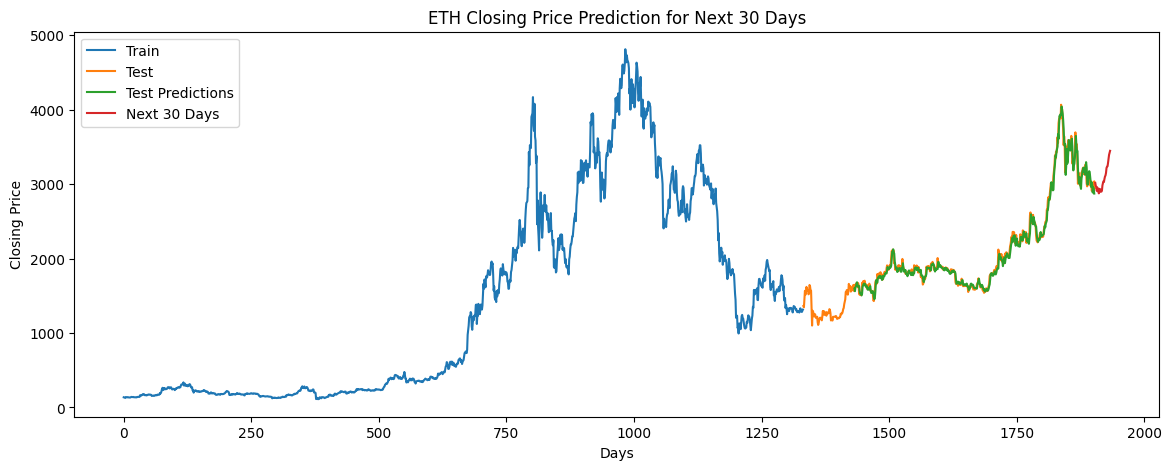

Predicted closing prices for the next 30 days:
[3015.4497 2975.8428 2962.82   2908.9014 2955.3726 2929.4983 2902.6052
 2875.705  2936.8547 2897.64   2927.8596 2901.2156 2898.9727 2911.853
 2982.1975 3013.4414 3038.3315 3030.867  3071.0679 3102.1226 3116.0723
 3150.6143 3216.4685 3234.527  3238.6519 3286.2493 3340.907  3393.4407
 3420.5361 3447.2551]


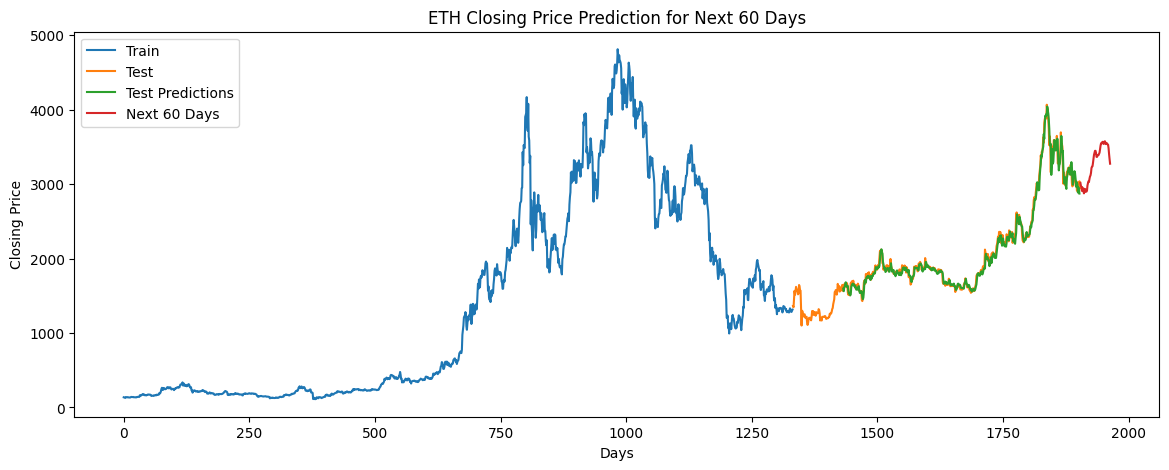

Predicted closing prices for the next 60 days:
[3015.4497 2975.8428 2962.82   2908.9014 2955.3726 2929.4983 2902.6052
 2875.705  2936.8547 2897.64   2927.8596 2901.2156 2898.9727 2911.853
 2982.1975 3013.4414 3038.3315 3030.867  3071.0679 3102.1226 3116.0723
 3150.6143 3216.4685 3234.527  3238.6519 3286.2493 3340.907  3393.4407
 3420.5361 3447.2551 3447.0366 3419.6836 3366.0518 3365.8694 3382.469
 3389.6897 3389.915  3406.2332 3422.589  3467.2253 3515.5483 3547.16
 3545.9917 3560.0747 3568.1487 3554.4617 3540.219  3550.3538 3574.2498
 3573.949  3539.4792 3537.432  3551.9497 3545.4197 3534.879  3529.6917
 3481.9614 3402.2375 3334.8215 3274.258 ]


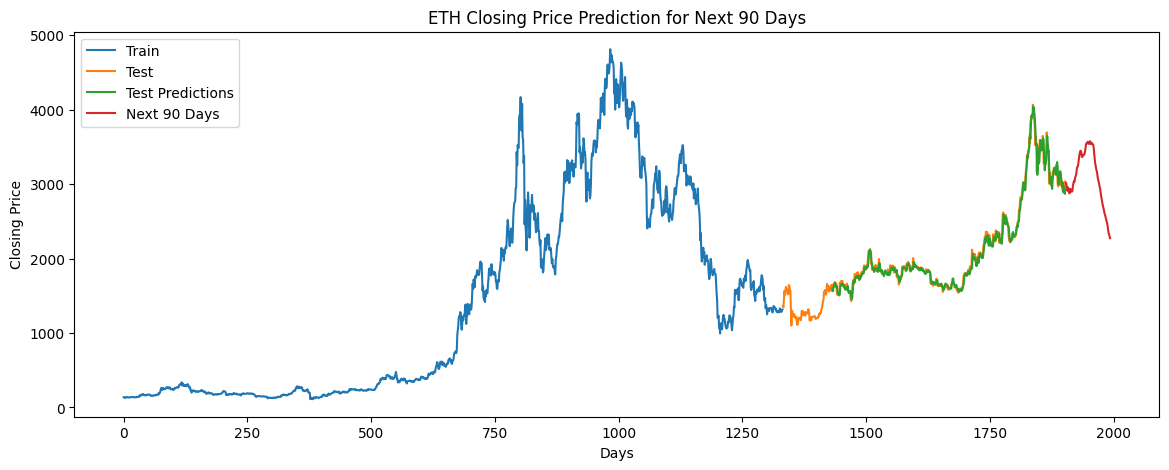

Predicted closing prices for the next 90 days:
[3015.4497 2975.8428 2962.82   2908.9014 2955.3726 2929.4983 2902.6052
 2875.705  2936.8547 2897.64   2927.8596 2901.2156 2898.9727 2911.853
 2982.1975 3013.4414 3038.3315 3030.867  3071.0679 3102.1226 3116.0723
 3150.6143 3216.4685 3234.527  3238.6519 3286.2493 3340.907  3393.4407
 3420.5361 3447.2551 3447.0366 3419.6836 3366.0518 3365.8694 3382.469
 3389.6897 3389.915  3406.2332 3422.589  3467.2253 3515.5483 3547.16
 3545.9917 3560.0747 3568.1487 3554.4617 3540.219  3550.3538 3574.2498
 3573.949  3539.4792 3537.432  3551.9497 3545.4197 3534.879  3529.6917
 3481.9614 3402.2375 3334.8215 3274.258  3238.4785 3203.3625 3175.5093
 3139.8638 3090.951  3055.9763 3030.394  2997.2505 2965.2944 2932.5427
 2883.7212 2835.5425 2802.0547 2762.5908 2723.8767 2693.934  2666.1685
 2632.3896 2603.575  2579.2559 2555.904  2527.1604 2499.203  2478.6147
 2439.6995 2385.8215 2344.123  2322.416  2297.9888 2273.425 ]


In [102]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'ETH Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **6:4**

In [103]:
df = pd.read_csv('ETH.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229981,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1899,2024-05-12,2911.658203,2953.047363,2902.201904,2928.701904,2928.701904,5908941395
1900,2024-05-13,2928.813965,2994.869141,2865.134521,2949.359619,2949.359619,13352264795
1901,2024-05-14,2949.213135,2959.546631,2863.545898,2881.157959,2881.157959,12444516140
1902,2024-05-15,2881.224609,3041.602295,2864.735352,3037.056641,3037.056641,14666902956


In [104]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [105]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [106]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [107]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [108]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [109]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [110]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
17/17 [==============================] - 4s 100ms/step - loss: 0.0513 - val_loss: 0.0133
Epoch 2/200
17/17 [==============================] - 1s 83ms/step - loss: 0.0121 - val_loss: 0.0064
Epoch 3/200
17/17 [==============================] - 1s 83ms/step - loss: 0.0094 - val_loss: 0.0049
Epoch 4/200
17/17 [==============================] - 1s 83ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 5/200
17/17 [==============================] - 2s 140ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 6/200
17/17 [==============================] - 2s 124ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 7/200
17/17 [==============================] - 1s 81ms/step - loss: 0.0055 - val_loss: 0.0066
Epoch 8/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0053 - val_loss: 0.0077
Epoch 9/200
17/17 [==============================] - 1s 82ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 10/200
17/17 [==============================] - 1s 88ms/step - loss: 0.0044 - val_loss: 0.0

In [111]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 15ms/step


In [112]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [113]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 191.74234605587796
Testing MAPE: 9.250647790068967
Testing MAE: 160.24878905280823


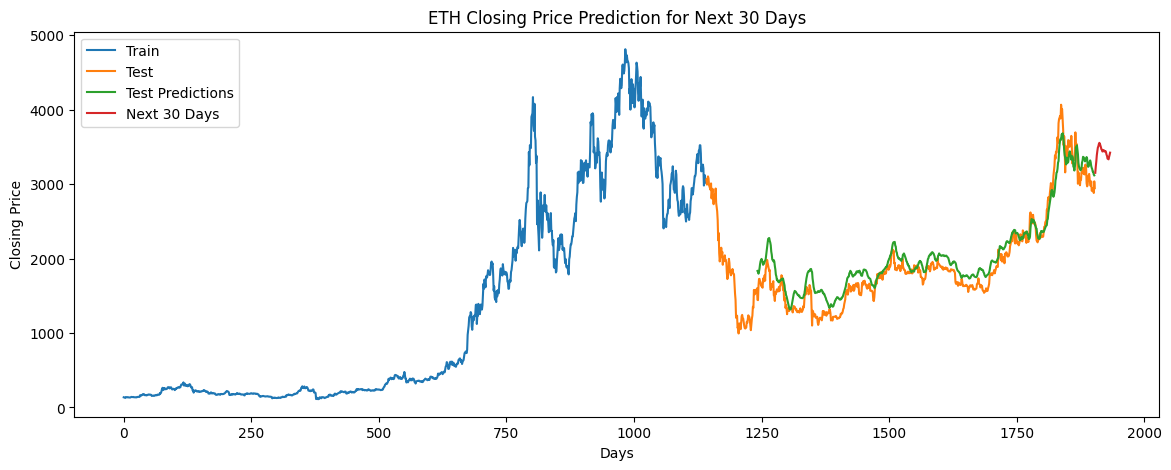

Predicted closing prices for the next 30 days:
[3151.9463 3238.1826 3305.513  3389.2632 3442.304  3489.8735 3507.1436
 3538.2524 3554.3303 3542.074  3519.1812 3496.9639 3466.4949 3462.851
 3437.9438 3453.0295 3442.284  3454.1992 3439.439  3436.8557 3444.2249
 3428.6985 3395.708  3379.308  3342.3887 3340.0813 3332.9287 3365.6868
 3391.794  3422.6758]


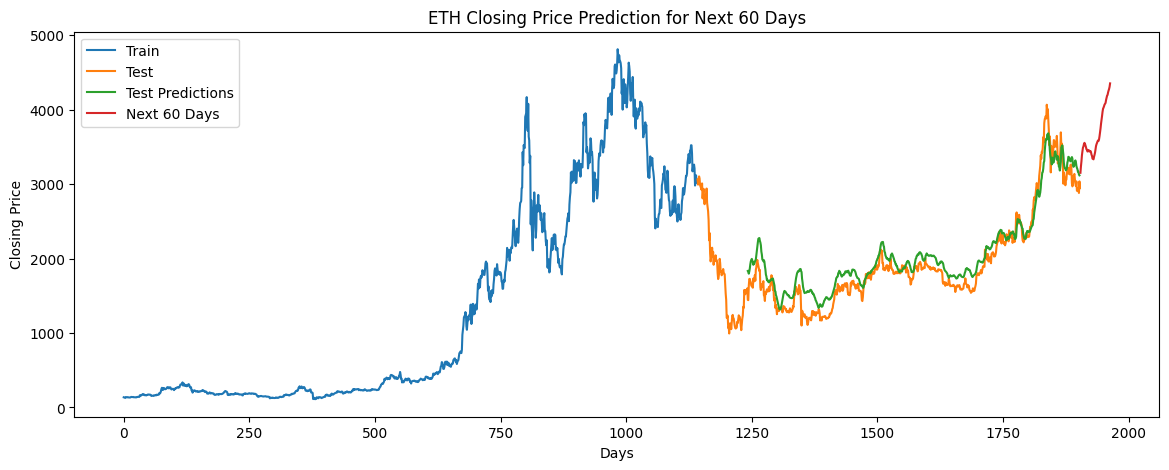

Predicted closing prices for the next 60 days:
[3151.9463 3238.1826 3305.513  3389.2632 3442.304  3489.8735 3507.1436
 3538.2524 3554.3303 3542.074  3519.1812 3496.9639 3466.4949 3462.851
 3437.9438 3453.0295 3442.284  3454.1992 3439.439  3436.8557 3444.2249
 3428.6985 3395.708  3379.308  3342.3887 3340.0813 3332.9287 3365.6868
 3391.794  3422.6758 3466.1838 3511.513  3536.1357 3553.7925 3572.8965
 3586.0767 3579.992  3600.7466 3643.1687 3695.0063 3748.0278 3811.7424
 3864.0464 3915.2593 3971.443  4012.954  4027.6702 4047.4    4068.6797
 4079.374  4091.08   4130.113  4159.182  4187.419  4198.293  4231.683
 4256.43   4277.6357 4307.192  4353.226 ]


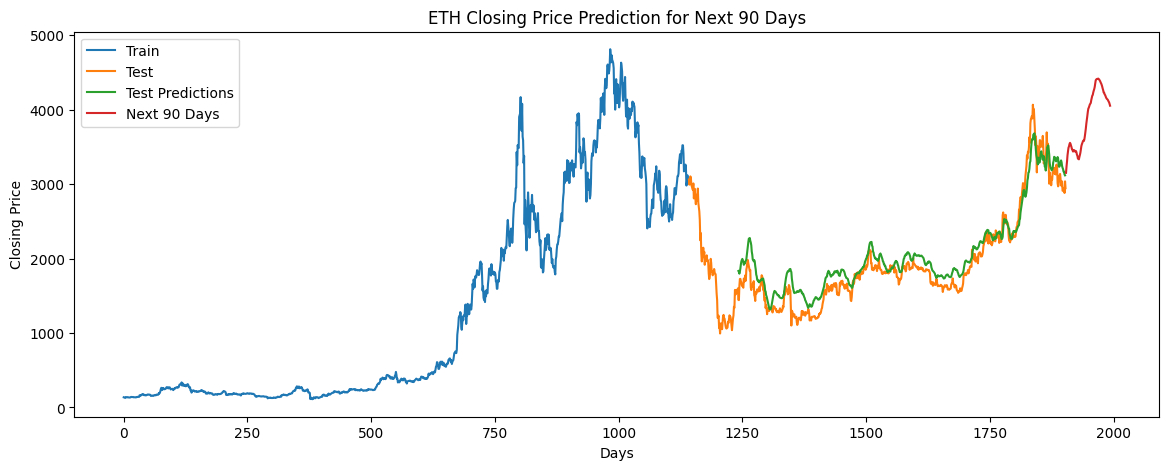

Predicted closing prices for the next 90 days:
[3151.9463 3238.1826 3305.513  3389.2632 3442.304  3489.8735 3507.1436
 3538.2524 3554.3303 3542.074  3519.1812 3496.9639 3466.4949 3462.851
 3437.9438 3453.0295 3442.284  3454.1992 3439.439  3436.8557 3444.2249
 3428.6985 3395.708  3379.308  3342.3887 3340.0813 3332.9287 3365.6868
 3391.794  3422.6758 3466.1838 3511.513  3536.1357 3553.7925 3572.8965
 3586.0767 3579.992  3600.7466 3643.1687 3695.0063 3748.0278 3811.7424
 3864.0464 3915.2593 3971.443  4012.954  4027.6702 4047.4    4068.6797
 4079.374  4091.08   4130.113  4159.182  4187.419  4198.293  4231.683
 4256.43   4277.6357 4307.192  4353.226  4395.265  4404.7393 4412.3296
 4413.0312 4411.772  4417.823  4410.755  4405.548  4392.2676 4382.1533
 4363.875  4351.743  4333.9644 4312.361  4284.485  4262.6304 4231.19
 4228.23   4205.8438 4196.028  4179.0527 4161.71   4149.682  4141.786
 4135.771  4124.4536 4109.2134 4098.9995 4076.0857 4053.3003]


In [114]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'ETH Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())